In [20]:
# basics
import numpy as np 
import pandas as pd 
import os
import sklearn
import warnings
import random

# plots
import seaborn as sns 
import matplotlib.pyplot as plt 

# databases
from sqlalchemy import create_engine

# sklearn
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_auc_score
import pickle

# like i'm 5
import eli5

In [21]:
# i know understand it's a pain to get feature names out of column tranformers
# https://johaupt.github.io/blog/columnTransformer_feature_names.html
def get_feature_names(column_transformer):
    """Get feature names from all transformers.
    Returns
    -------
    feature_names : list of strings
        Names of the features produced by transform.
    """
    # Remove the internal helper function
    #check_is_fitted(column_transformer)
    
    # Turn loopkup into function for better handling with pipeline later
    def get_names(trans):
        # >> Original get_feature_names() method
        if trans == 'drop' or (
                hasattr(column, '__len__') and not len(column)):
            return []
        if trans == 'passthrough':
            if hasattr(column_transformer, '_df_columns'):
                if ((not isinstance(column, slice))
                        and all(isinstance(col, str) for col in column)):
                    return column
                else:
                    return column_transformer._df_columns[column]
            else:
                indices = np.arange(column_transformer._n_features)
                return ['x%d' % i for i in indices[column]]
        if not hasattr(trans, 'get_feature_names'):
        # >>> Change: Return input column names if no method avaiable
            # Turn error into a warning
            warnings.warn("Transformer %s (type %s) does not "
                                 "provide get_feature_names. "
                                 "Will return input column names if available"
                                 % (str(name), type(trans).__name__))
            # For transformers without a get_features_names method, use the input
            # names to the column transformer
            if column is None:
                return []
            else:
                return [name + "__" + f for f in column]

        return [name + "__" + f for f in trans.get_feature_names()]
    
    ### Start of processing
    feature_names = []
    
    # Allow transformers to be pipelines. Pipeline steps are named differently, so preprocessing is needed
    if type(column_transformer) == sklearn.pipeline.Pipeline:
        l_transformers = [(name, trans, None, None) for step, name, trans in column_transformer._iter()]
    else:
        # For column transformers, follow the original method
        l_transformers = list(column_transformer._iter(fitted=True))
    
    
    for name, trans, column, _ in l_transformers: 
        if type(trans) == sklearn.pipeline.Pipeline:
            # Recursive call on pipeline
            _names = get_feature_names(trans)
            # if pipeline has no transformer that returns names
            if len(_names)==0:
                _names = [name + "__" + f for f in column]
            feature_names.extend(_names)
        else:
            feature_names.extend(get_names(trans))
    
    return feature_names


## Exploratory Analysis

In [49]:
# read in the data
dt = pd.read_csv("/opt/static/births.csv")

In [23]:
# connect to the database just in case
PGHOST = os.environ["PGHOST"]
PGUSER = os.environ["PGUSER"]
PGPASSWORD = os.environ["PGPASSWORD"]
PGPORT = os.environ["PGPORT"]
PGDATABASE = os.environ["PGDATABASE"]
engine = create_engine("postgresql://{}:{}@{}:{}/{}".format(PGUSER,PGPASSWORD,PGHOST,PGPORT,PGDATABASE))
# upload the final data to a relational database
# dt.to_sql("dt", engine, index = False)

In [50]:
# high level types
dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3096936 entries, 0 to 3096935
Data columns (total 6 columns):
 #   Column                        Dtype 
---  ------                        ----- 
 0   age_group                     object
 1   reported_race_ethnicity       object
 2   previous_births               object
 3   tobacco_use_during_pregnancy  object
 4   adequate_prenatal_care        object
 5   preterm_indicator             int64 
dtypes: int64(1), object(5)
memory usage: 141.8+ MB


In [51]:
# are there any true duplicates
dupes = dt[dt.duplicated()]
dupes.shape[0]

3096344

In [52]:
# what does it look like
dt.head()

,age_group,reported_race_ethnicity,previous_births,tobacco_use_during_pregnancy,adequate_prenatal_care,preterm_indicator
0,Under 15 yrs,"White, non-Hispanic",None,Yes,Inadequate,0
1,Under 15 yrs,"White, non-Hispanic",None,Yes,Inadequate,0
2,Under 15 yrs,"White, non-Hispanic",None,Yes,Inadequate,0
3,Under 15 yrs,"White, non-Hispanic",None,Yes,Inadequate,0
4,Under 15 yrs,"White, non-Hispanic",None,Yes,Inadequate,0


In [54]:
# describe the thing you're trying to predict
outcome = "preterm_indicator"
dt[outcome].describe()

count    3.096936e+06
mean     9.220274e-02
std      2.893120e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.000000e+00
Name: preterm_indicator, dtype: float64

In [55]:
# what is the prevalance of thing we're trying to predict
dt[outcome].sum() / dt.shape[0]

0.09220274490657863

In [56]:
# what are the relevant features, remove identifiers and target variables
features = list(set(dt.columns).difference(set([outcome,"Id"])))
features

['previous_births',
 'reported_race_ethnicity',
 'age_group',
 'tobacco_use_during_pregnancy',
 'adequate_prenatal_care']

In [57]:
# break out into numeric features and categorical features
numerics = dt[features].select_dtypes(include='number').columns.tolist()
numerics

[]

In [58]:
categoricals = dt[features].select_dtypes(exclude='number').columns.tolist()
categoricals

['previous_births',
 'reported_race_ethnicity',
 'age_group',
 'tobacco_use_during_pregnancy',
 'adequate_prenatal_care']

In [32]:
# univariate boxplot of each feaure in isolation
if len(numerics) > 0:
    dt[numerics].boxplot(grid=False, vert=False,fontsize=15, figsize=(12,10))

In [33]:
# look at each histogram in isolution
if len(numerics) > 0:
    for col in numerics:
        dt[[col]].hist()

In [34]:
# how are these feature correlated with each other
if len(numerics) > 0:
    sns.heatmap(dt[numerics].corr(), annot=True)

In [35]:
# how are the missing values correlated to each other
if len(numerics) > 0:
    sns.heatmap(dt[numerics].isna().corr(), annot=True)

In [36]:
# categorical feature cardinality
cardinality = {}
for item in categoricals:
    cardinality[item] = len(dt[item].unique())
cardinality    

{'previous_births': 2,
 'reported_race_ethnicity': 4,
 'age_group': 10,
 'tobacco_use_during_pregnancy': 2,
 'adequate_prenatal_care': 2}

In [37]:
# things that aren't features
dates = [x for x in cardinality.keys() if "date" in x]
categoricals = list(set(categoricals).difference(set(dates)))

# the final features are the less cardinal categories
categoricals = list(set(categoricals).difference(set(["city"])))
categoricals

['previous_births',
 'reported_race_ethnicity',
 'age_group',
 'tobacco_use_during_pregnancy',
 'adequate_prenatal_care']

## Training and Validation Regions

In [38]:
# globally remove any instance where the outcome is unknown
if dt[outcome].isna().sum() > 0:
    dt = dt[~dt[outcome].isna()]
dt[outcome].isna().sum()

0

In [39]:
# are the rows iid
dt["id"] = dt.index
identifier = "id"
dt[[identifier]].duplicated().sum() / dt.shape[0]

0.0

In [21]:
# they are not iid, so let's split into three disjoint sets (60,20,20)
# this is terribly inefficient but ok today
patients = list(dt[identifier].unique()) 
random.seed(54231)
random.shuffle(patients)

# take 60% for the training set
train = [x for i, x in enumerate(patients) if i % 10 < 6]

# who is left
remainder = [x for x in patients if x not in train]

# split the rest in half
valid = [x for i, x in enumerate(remainder) if i % 2 == 0]
test =  [x for x in remainder if x not in valid]

KeyboardInterrupt: 

In [66]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(dt[features],dt[outcome],test_size=0.4)
X_test,X_valid,y_test,y_valid = train_test_split(X_test,y_test,test_size=0.5)

In [67]:
y_test.sum() / len(y_test)

0.0924236382100367

In [68]:
y_train.sum() / len(y_train)

0.09202378050125903

In [69]:
y_valid.sum() / len(y_train)

0.030839631226788206

In [43]:
def check_overlap(train: list, valid: list, test: list) -> None:
    if len(set(train).intersection(set(test))) > 0:
        raise Exception("overlapping patients")
    if len(set(train).intersection(set(valid))) > 0:
        raise Exception("overlapping patients")
    if len(set(valid).intersection(set(test))) > 0:
        raise Exception("overlapping patients")
        
check_overlap(train, valid, test)

NameError: name 'train' is not defined

In [ ]:
# split into distinct regions
X_train = dt.loc[dt[identifier].isin(train), features]
y_train = dt.loc[dt[identifier].isin(train), outcome]
X_test = dt.loc[dt[identifier].isin(test), features]
y_test = dt.loc[dt[identifier].isin(test), outcome]
X_valid = dt.loc[dt[identifier].isin(valid), features]
y_valid = dt.loc[dt[identifier].isin(valid), outcome]
{
    "train": X_train.shape[0] / dt.shape[0],
    "valid": X_valid.shape[0] / dt.shape[0],
    "test": X_test.shape[0] / dt.shape[0],
}

## Feature pipeline

In [70]:
# now that we're roughly iid, simple pipelines transformation
num_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())
])

# it's ok to one-hot the less cardinal things
cat_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# combine them together into a single pipeline
feature_pipeline = ColumnTransformer(transformers=[
    ('numerics', num_pipeline, numerics),
    ('categoricals', cat_pipeline, categoricals)
])

## Lasso

In [71]:
# i always build a linear model first
lm = LogisticRegression(penalty="l1",solver="liblinear")
lm_pipeline = Pipeline(steps=[
    ('features', feature_pipeline),
    ('model', lm)
])
lm_pipeline.fit(X_train, y_train)
lm_prediction = lm_pipeline.predict(X_valid)

In [72]:
# summarize
lm_prediction = lm_pipeline.predict(X_valid)

## Boosted Tree

In [73]:
# i always build a linear model first
def estimate(max_depth: int) -> tuple:
    """estimate a model to a certain depth"""
    gb = GradientBoostingClassifier(max_depth=max_depth)
    gb_pipeline = Pipeline(steps=[
        ('features', feature_pipeline),
        ('model', gb)
    ])
    gb_pipeline.fit(X_train, y_train)
    gb_prediction = gb_pipeline.predict(X_valid)
    train = roc_auc_score(gb_pipeline.predict(X_train), y_train)
    valid = roc_auc_score(gb_pipeline.predict(X_valid), y_valid)
    return train, valid

In [74]:
# how does model performance vary with complexity (depth)
depth = list(range(1,10))
train_roc=list()
valid_roc=list()
for i in depth:
    train, valid = estimate(max_depth=i)
    train_roc.append(train)
    valid_roc.append(valid)
plt.plot(depth, train_roc, label = "train")
plt.plot(depth, valid_roc, label = "valid")
plt.legend()
plt.show()

ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.

In [75]:
# choose a reasonable depth without overfitting
gb = GradientBoostingClassifier(max_depth=3)
gb_pipeline = Pipeline(steps=[
    ('features', feature_pipeline),
    ('model', gb)
])
gb_pipeline.fit(X_train, y_train)
gb_prediction = gb_pipeline.predict(X_valid)

## Compare models

### Confusion Matrix

In [76]:
# confusion matrix
confusion_matrix(y_valid,gb_prediction)

array([[562068,     15],
       [ 57299,      6]])

In [77]:
# confusion matrix
confusion_matrix(y_valid,lm_prediction)

array([[562076,      7],
       [ 57302,      3]])

### Area under the ROC curve

In [78]:
roc_auc_score(y_valid,lm_prediction)

0.5000199488879913

In [79]:
roc_auc_score(y_valid,gb_prediction)

0.500039008227642

### Precision and recall

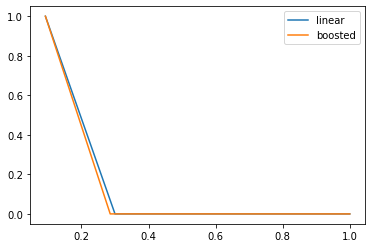

In [80]:
# precision and recall
lm_precision, lm_recall, lm_thresholds = precision_recall_curve(y_valid, lm_prediction)
gb_precision, gb_recall, gb_thresholds = precision_recall_curve(y_valid, gb_prediction)
plt.plot(lm_precision, lm_recall, label = "linear")
plt.plot(gb_precision, gb_recall, label = "boosted")
plt.legend()
plt.show()

### Important features

In [81]:
# important features
extracted_features = get_feature_names(lm_pipeline.named_steps["features"])
eli5.explain_weights(
    lm_pipeline.named_steps['model'], 
    top=20, 
    feature_names=extracted_features
)

/tmp/ipykernel_16/4230822473.py:32: UserWarning: Transformer imputer (type SimpleImputer) does not provide get_feature_names. Will return input column names if available
  warnings.warn("Transformer %s (type %s) does not "
/tmp/ipykernel_16/4230822473.py:32: UserWarning: Transformer scaler (type MinMaxScaler) does not provide get_feature_names. Will return input column names if available
  warnings.warn("Transformer %s (type %s) does not "
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Explanation(estimator="LogisticRegression(penalty='l1', solver='liblinear')", description="\nFeatures with largest coefficients.\nCaveats:\n1. Be careful with features which are not\n   independent - weights don't show their importance.\n2. If scale of input features is different then scale of coefficients\n   will also be different, making direct comparison between coefficient values\n   incorrect.\n3. Depending on regularization, rare features sometimes may have high\n   coefficients; this doesn't mean they contribute much to the\n   classification result for most examples.\n", error=None, method='linear model', is_regression=False, targets=[TargetExplanation(target=1, feature_weights=FeatureWeights(pos=[FeatureWeight(feature='encoder__x2_50+ yrs', weight=1.6814649128108103, std=None, value=None), FeatureWeight(feature='encoder__x2_45 to 49 yrs', weight=1.1683174394892608, std=None, value=None), FeatureWeight(feature='encoder__x2_Under 15 yrs', weight=0.5616688990894065, std=None, value=None), FeatureWeight(feature='encoder__x2_40 to 44 yrs', weight=0.45713299348417713, std=None, value=None), FeatureWeight(feature='<BIAS>', weight=0.36954288321161904, std=None, value=None), FeatureWeight(feature='encoder__x2_15 to 17 yrs', weight=0.22780860597238495, std=None, value=None), FeatureWeight(feature='encoder__x2_35 to 39 yrs', weight=0.21375997841634506, std=None, value=None), FeatureWeight(feature='encoder__x2_18 to 19 yrs', weight=0.057495956954323045, std=None, value=None), FeatureWeight(feature='encoder__x2_30 to 34 yrs', weight=0.05168244175117403, std=None, value=None)], neg=[FeatureWeight(feature='encoder__x1_White, non-Hispanic', weight=-1.3713965918433488, std=None, value=None), FeatureWeight(feature='encoder__x1_Asian, non-Hispanic', weight=-1.311664720660827, std=None, value=None), FeatureWeight(feature='encoder__x4_Inadequate', weight=-1.1983044511414696, std=None, value=None), FeatureWeight(feature='encoder__x1_Hispanic (of any race)', weight=-1.0871180284593696, std=None, value=None), FeatureWeight(feature='encoder__x3_No', weight=-0.7213794904612509, std=None, value=None), FeatureWeight(feature='encoder__x1_Black, non-Hispanic', weight=-0.6088565370525885, std=None, value=None), FeatureWeight(feature='encoder__x4_Adequate', weight=-0.5629283543817872, std=None, value=None), FeatureWeight(feature='encoder__x3_Yes', weight=-0.2685378619371388, std=None, value=None), FeatureWeight(feature='encoder__x0_One, Two, Three or More', weight=-0.15077810330602331, std=None, value=None), FeatureWeight(feature='encoder__x0_None', weight=-0.14866265564601708, std=None, value=None), FeatureWeight(feature='encoder__x2_25 to 29 yrs', weight=-0.05844441127818088, std=None, value=None)], pos_remaining=0, neg_remaining=1), proba=None, score=None, weighted_spans=None, heatmap=None)], feature_importances=None, decision_tree=None, highlight_spaces=None, transition_features=None, image=None)

In [82]:
# important features
extracted_features = get_feature_names(gb_pipeline.named_steps["features"])
eli5.explain_weights(
    gb_pipeline.named_steps['model'], 
    top=20, 
    feature_names=extracted_features
)

/tmp/ipykernel_16/4230822473.py:32: UserWarning: Transformer imputer (type SimpleImputer) does not provide get_feature_names. Will return input column names if available
  warnings.warn("Transformer %s (type %s) does not "
/tmp/ipykernel_16/4230822473.py:32: UserWarning: Transformer scaler (type MinMaxScaler) does not provide get_feature_names. Will return input column names if available
  warnings.warn("Transformer %s (type %s) does not "


Weight,Feature
0.2901 ± 0.2364,"encoder__x1_Black, non-Hispanic"
0.2443 ± 0.2427,encoder__x4_Inadequate
0.1128 ± 0.1881,encoder__x4_Adequate
0.0666 ± 0.1500,encoder__x3_No
0.0341 ± 0.1919,encoder__x2_40 to 44 yrs
0.0336 ± 0.1360,encoder__x3_Yes
0.0306 ± 0.0980,encoder__x1_Hispanic (of any race)
0.0302 ± 0.1905,"encoder__x1_White, non-Hispanic"
0.0288 ± 0.2112,encoder__x2_45 to 49 yrs
0.0281 ± 0.2214,encoder__x2_35 to 39 yrs


## Final Test Set Performance

In [83]:
# make sure the valid set was not overfit now that we chose a model
gb_test_prediction = gb_pipeline.predict(X_test)
confusion_matrix(y_test,gb_test_prediction)

array([[562122,     19],
       [ 57233,     13]])

In [84]:
confusion_matrix(y_valid,gb_prediction)

array([[562068,     15],
       [ 57299,      6]])

In [85]:
{
    "valid": roc_auc_score(y_valid,gb_prediction),
    "test": roc_auc_score(y_test,gb_test_prediction)
}

{'valid': 0.500039008227642, 'test': 0.5000966453765459}

In [86]:
pickle.dump(gb_pipeline, open('/opt/static/estimated.sav', 'wb'))